# Clasificador Binario

## Librerías

In [1]:
!pip install fastai -Uq

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 197 kB 10.1 MB/s 
     |████████████████████████████████| 59 kB 9.1 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [2]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 -O val.zip


--2022-05-20 09:19:15--  https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/o1eaoae59qgdo4i/Training_Set_Pre.zip [following]
--2022-05-20 09:19:15--  https://www.dropbox.com/s/raw/o1eaoae59qgdo4i/Training_Set_Pre.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb5ecb6e924f38f8d3d32f59074.dl.dropboxusercontent.com/cd/0/inline/BllR7oU3wpKRux1r-0ApaFPsDyF9vSTIDfrYFRQFD3owkGpfkm8ZwZhQddHhf37p2nKu7NaGgJKbyVGYm0F7nj-xcp4PXdgwikcl-IuImsIFDgfy56SERa5UAHB6U6vfcv0PxuK4NQ0Bm5FwUCLYAEVd5-pPHqpOzY8diAJaCH6Csg/file# [following]
--2022-05-20 09:19:15--  https://ucb5ecb6e924f38f8d3d32f59074.dl.dropboxusercontent.com/cd/0/inline/BllR7oU3wpKRux1r-0ApaFPsDyF9vSTIDfrYFR

In [3]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [4]:
#Train Normal y Enfermedad
trainN='dataset/train/normal'
trainE='dataset/train/enfermedad'

testN='dataset/test/normal'
testE='dataset/test/enfermedad'

valN='dataset/val/normal'
valE='dataset/val/enfermedad'

train='dataset/train'
test='dataset/test'
val='dataset/val'

!mkdir dataset

!mkdir '$train'
!mkdir '$test'
!mkdir '$val'

!mkdir "$trainN"
!mkdir "$trainE"

!mkdir "$testN"
!mkdir "$testE"

!mkdir "$valN"
!mkdir "$valE"

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [5]:
path = Path('dataset/')

In [6]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [10]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [8]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [13]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Creamos la estructura mencionada antes

In [14]:
import shutil
for id, enf in zip(df_train['ID'], df_train['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(str(trainPath)+'/Training/' + str(id) + '.png', trainN)
    else:
        shutil.move(str(trainPath)+'/Training/' + str(id) + '.png', trainE)      

In [15]:
for id, enf in zip(df_test['ID'], df_test['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(str(testPath)+'/Test/' + str(id) + '.png', testN)
    else:
        shutil.move(str(testPath)+'/Test/' + str(id) + '.png', testE)

In [16]:
for id, enf in zip(df_val['ID'], df_val['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(str(valPath)+'/Validation/' + str(id) + '.png', valN)
    else:
        shutil.move(str(valPath)+'/Validation/' + str(id) + '.png', valE)

In [17]:
#Hemos movido las imágenes correctamente
len(Path(trainN).ls()) #401
len(Path(trainE).ls()) #1519

1519

In [18]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

0

Ahora que ya tenemos la estructura deseado empezamos a construir el modelo:

In [19]:
trainPath = Path('dataset/train')

## Cargando el dataset

In [20]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [21]:
dls = db.dataloaders(trainPath,bs=128)

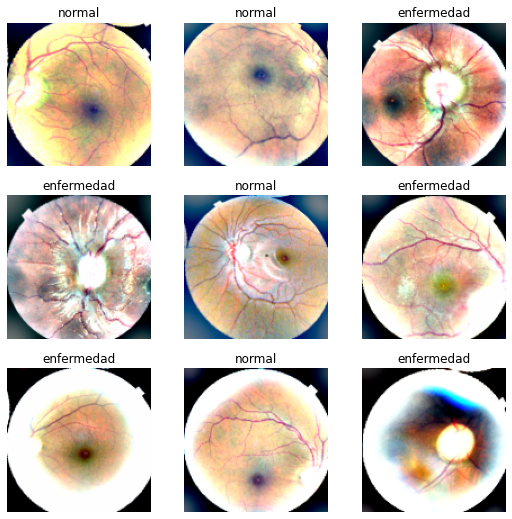

In [22]:
dls.show_batch()

In [23]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=8),
    SaveModelCallback(fname='modelResnet18')  
]

In [24]:
learn = cnn_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()


/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.012022644281387329, steep=0.0003311311302240938, valley=0.0012022644514217973, slide=0.0063095735386013985)

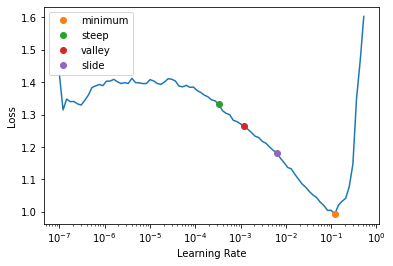

In [25]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,time
0,1.177331,4.370639,0.622396,00:06


Better model found at epoch 0 with valid_loss value: 4.370638847351074.


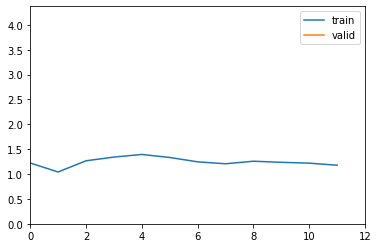

epoch,train_loss,valid_loss,accuracy,time
0,0.886792,1.963274,0.518229,00:06
1,0.625962,0.419174,0.794271,00:06
2,0.519159,0.753076,0.669271,00:06
3,0.455826,0.615433,0.760417,00:06
4,0.406447,0.430396,0.817708,00:06
5,0.364231,0.808025,0.817708,00:06
6,0.344754,0.356504,0.846354,00:06
7,0.341123,0.439895,0.815104,00:06
8,0.348841,20.083609,0.807292,00:06
9,0.339236,7.710409,0.776042,00:06


Better model found at epoch 0 with valid_loss value: 1.963274359703064.


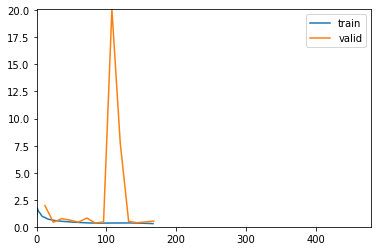

Better model found at epoch 1 with valid_loss value: 0.41917428374290466.
Better model found at epoch 6 with valid_loss value: 0.3565039336681366.
No improvement since epoch 6: early stopping


In [26]:
learn.fine_tune(40,base_lr=1e-1)

Exportamos el modelo

In [28]:
learn.to_fp32()
learn.export('modeloBinario.pkl')

## Evaluando el modelo

In [29]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [30]:
learn.dls = dlsTest

El valor de la función de perdida es de 0.53 y su accuracy es del 74.5%.

In [31]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.745312511920929.


(#2) [0.5356293320655823,0.745312511920929]

## Interpretación del modelo

In [32]:
learn.dls=dls

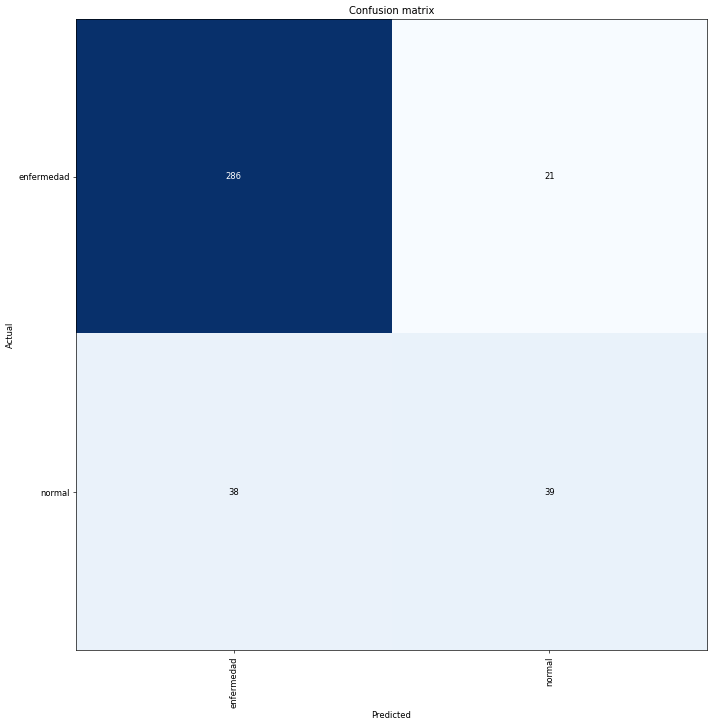

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)